In [1]:
import torch
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
from typing import List, Set

# First define the MSP function exactly as in your training code
class MSPFunction:
    def __init__(self, P: int, sets: List[Set[int]]):
        self.P = P
        self.sets = sets
    
    def evaluate(self, z: torch.Tensor) -> torch.Tensor:
        device = z.device
        batch_size = z.shape[0]
        result = torch.zeros(batch_size, dtype=torch.float32, device=device)
        
        for S in self.sets:
            term = torch.ones(batch_size, dtype=torch.float32, device=device)
            for idx in S:
                term = term * z[:, idx]
            result = result + term
            
        return result

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            layers.extend([
                torch.nn.Linear(prev_dim, hidden_size),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def get_feature_matrix(model, X):
    """Get the feature matrix (pre-last layer activations) for input X"""
    model.eval()
    with torch.no_grad():
        # Remove the last layer
        feature_extractor = torch.nn.Sequential(*list(model.network.children())[:-1])
        features = feature_extractor(X)
    return features

def calculate_cumulative_quality(feature_matrix, target_function, max_k=None):
    """Calculate eigenfunctions and cumulative quality Π*(k)"""
    # Calculate eigenfunctions using SVD
    U, S, _ = torch.linalg.svd(feature_matrix, full_matrices=False)
    
    if max_k is None:
        max_k = U.shape[1]
    
    # Apply QR decomposition for numerical stability
    Q, R = qr(U.cpu().numpy())
    Q = torch.tensor(Q, device=U.device)
    
    cumulative_quality = torch.zeros(max_k)
    
    for k in range(max_k):
        # Take first k eigenvectors
        Qk = Q[:, :k+1]
        
        # Calculate projection onto target function
        projection = torch.matmul(Qk, torch.matmul(Qk.T, target_function))
        quality = torch.norm(projection)**2 / torch.norm(target_function)**2
        cumulative_quality[k] = quality
        
    return cumulative_quality, S

def plot_cumulative_quality(qualities, title="Cumulative Quality Π*(k)"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(qualities) + 1), qualities.cpu().numpy())
    plt.xlabel('k')
    plt.ylabel('Π*(k)')
    plt.title(title)
    plt.grid(True)
    plt.xscale('log')
    return plt

# FILL IN THESE VALUES:
MODEL_PATH = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_yang/final_model_h50_d4_n30000_lr0.001_mup_pennington_shuffled_20250104_182751_rank1.pt"  # Path to your saved model
DATASET_PATH = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_yang/train_dataset_h50_d4_n30000_lr0.001_mup_pennington_shuffled_20250104_182751_rank1.pt"  # Path to your saved dataset
MSP_SETS = [{7},{2,7},{0,2,7},{5,7,4},{1},{0,4},{3,7},{0,1,2,3,4,6,7}]  # Confirm these are your sets
P = 8  # The P value you used
d = 30  # Input dimension
hidden_size = 50  # Model hidden size
depth = 4  # Model depth
mode = 'mup_pennington'  # Model mode

# Load everything
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
dataset = torch.load(DATASET_PATH)
X = dataset['X'].to(device)
y = dataset['y'].to(device)

# Initialize model and load weights
model = DeepNN(d, hidden_size, depth, mode).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# Create MSP function for target function
msp = MSPFunction(P, MSP_SETS)

# Get feature matrix
feature_matrix = get_feature_matrix(model, X)

# Calculate and plot cumulative quality
qualities, singular_values = calculate_cumulative_quality(feature_matrix, y)
plt = plot_cumulative_quality(qualities)
plt.show()

# Print some statistics
print(f"Final cumulative quality: {qualities[-1]:.4f}")
print(f"Number of features needed for 90% quality: {torch.sum(qualities < 0.9).item() + 1}")

/tmp/ipykernel_2027561/481685998.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(DATASET_PATH)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_yang/train_dataset_h50_d4_n30000_lr0.001_mup_pennington_shuffled_20250104_182751_rank1.pt'

/tmp/ipykernel_2351495/3427460319.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_path)
/tmp/ipykernel_2351495/3427460319.py:128: FutureWa

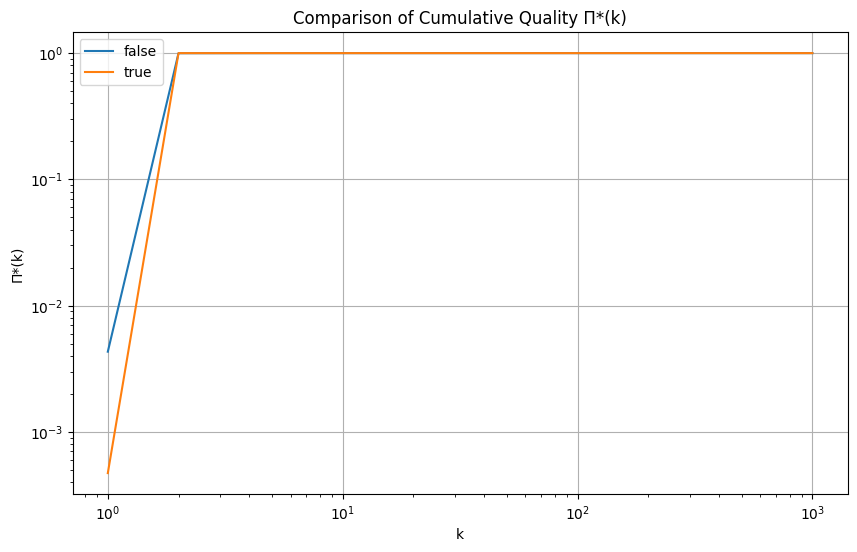


Statistics for false:
Final cumulative quality: 1.0000
Number of features needed for 90% quality: 2

Statistics for true:
Final cumulative quality: 1.0000
Number of features needed for 90% quality: 2


In [1]:
import torch
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
from typing import List, Set

# First define the MSP function exactly as in your training code
class MSPFunction:
    def __init__(self, P: int, sets: List[Set[int]]):
        self.P = P
        self.sets = sets
    
    def evaluate(self, z: torch.Tensor) -> torch.Tensor:
        device = z.device
        batch_size = z.shape[0]
        result = torch.zeros(batch_size, dtype=torch.float32, device=device)
        
        for S in self.sets:
            term = torch.ones(batch_size, dtype=torch.float32, device=device)
            for idx in S:
                term = term * z[:, idx]
            result = result + term
            
        return result

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            layers.extend([
                torch.nn.Linear(prev_dim, hidden_size),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def get_feature_matrix(model, X):
    """Get the feature matrix (pre-last layer activations) for input X"""
    model.eval()
    with torch.no_grad():
        # Remove the last layer
        feature_extractor = torch.nn.Sequential(*list(model.network.children())[:-1])
        features = feature_extractor(X)
    return features

def calculate_cumulative_quality(feature_matrix, target_function, max_k=None):
    """Calculate eigenfunctions and cumulative quality Π*(k)"""
    # Calculate eigenfunctions using SVD
    U, S, _ = torch.linalg.svd(feature_matrix, full_matrices=False)
    
    if max_k is None:
        max_k = U.shape[1]
    
    # Apply QR decomposition for numerical stability
    Q, R = qr(U.cpu().numpy())
    Q = torch.tensor(Q, device=U.device)
    
    cumulative_quality = torch.zeros(max_k)
    
    for k in range(max_k):
        # Take first k eigenvectors
        Qk = Q[:, :k+1]
        
        # Calculate projection onto target function
        projection = torch.matmul(Qk, torch.matmul(Qk.T, target_function))
        quality = torch.norm(projection)**2 / torch.norm(target_function)**2
        cumulative_quality[k] = quality
        
    return cumulative_quality, S

def plot_cumulative_qualities(qualities_list, labels, title="Cumulative Quality Π*(k)", save_path=None):
    plt.figure(figsize=(10, 6))
    
    for qualities, label in zip(qualities_list, labels):
        plt.plot(range(1, len(qualities) + 1), qualities.cpu().numpy(), label=label)
    
    plt.xlabel('k')
    plt.ylabel('Π*(k)')
    plt.title(title)
    plt.grid(True)
    plt.xscale('log')
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
    
    return plt

# FILL IN THESE VALUES:
MODEL_PATH_1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/final_model_h1000_d4_n8000_lr0.001_mup_pennington_20250104_183809_rank0.pt"  # Path to first model
DATASET_PATH_1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/train_dataset_h1000_d4_n8000_lr0.001_mup_pennington_20250104_183809_rank0.pt"  # Path to first dataset
LABEL_1 = "false"  # Label for first model

MODEL_PATH_2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_antro_newmsp/final_model_h1000_d4_n8000_lr0.001_mup_pennington_shuffled_20250104_184500_rank0.pt"  # Path to second model
DATASET_PATH_2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_antro_newmsp/train_dataset_h1000_d4_n8000_lr0.001_mup_pennington_shuffled_20250104_184500_rank0.pt"  # Path to second dataset
LABEL_2 = "true"  # Label for second model

MSP_SETS = [{1},{1,3},{4},{2,4},{0,2,1},{1,5,4},{6},{0,7},{7,8,0,1,2},{0,1,2,3,4,6,7,10},{1,9,3}]  # Confirm these are your sets
P = 9  # The P value you used
d = 35  # Input dimension
hidden_size = 1000  # Model hidden size
depth = 4  # Model depth
mode = 'mup_pennington'  # Model mode

# Optional: path to save the plot
SAVE_PLOT_PATH = None  # e.g., "feature_quality_comparison.png"

# Load everything
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to process one model
def process_model(model_path, dataset_path):
    # Load dataset
    dataset = torch.load(dataset_path)
    X = dataset['X'].to(device)
    y = dataset['y'].to(device)
    
    # Initialize model and load weights
    model = DeepNN(d, hidden_size, depth, mode).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Get feature matrix
    feature_matrix = get_feature_matrix(model, X)
    
    # Calculate cumulative quality
    qualities, singular_values = calculate_cumulative_quality(feature_matrix, y)
    
    return qualities, singular_values

# Process both models
qualities_1, singular_values_1 = process_model(MODEL_PATH_1, DATASET_PATH_1)
qualities_2, singular_values_2 = process_model(MODEL_PATH_2, DATASET_PATH_2)

# Plot both curves
plt = plot_cumulative_qualities(
    [qualities_1, qualities_2],
    [LABEL_1, LABEL_2],
    title="Comparison of Cumulative Quality Π*(k)",
    save_path=SAVE_PLOT_PATH
)
plt.yscale('log')
plt.show()

# Print statistics for both models
print(f"\nStatistics for {LABEL_1}:")
print(f"Final cumulative quality: {qualities_1[-1]:.4f}")
print(f"Number of features needed for 90% quality: {torch.sum(qualities_1 < 0.9).item() + 1}")

print(f"\nStatistics for {LABEL_2}:")
print(f"Final cumulative quality: {qualities_2[-1]:.4f}")
print(f"Number of features needed for 90% quality: {torch.sum(qualities_2 < 0.9).item() + 1}")

/tmp/ipykernel_3494059/380770612.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_path)
/tmp/ipykernel_3494059/380770612.py:137: FutureWarn

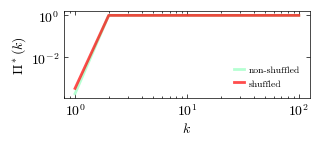


Statistics for non-shuffled:
Final cumulative quality: 1.0000
Number of features needed for 90% quality: 2

Statistics for shuffled:
Final cumulative quality: 1.0000
Number of features needed for 90% quality: 2


In [1]:
import torch
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

def setup_science_style():
    """Set up consistent science styling"""
    plt.style.use('default')
    mpl.rcParams.update({
        'figure.figsize': (1.3, 2.5),
        'figure.dpi': 100,
        'font.family': 'serif',
        'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
        'text.usetex': False,
        'axes.formatter.use_mathtext': True,
        'mathtext.fontset': 'cm',
        'axes.linewidth': 0.5,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'axes.spines.left': True,
        'axes.spines.bottom': True,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 1.5,
        'ytick.minor.size': 1.5,
        'xtick.top': True,
        'ytick.right': True,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 3,
        'legend.frameon': False,
        'legend.borderpad': 0,
        'legend.borderaxespad': 1.0,
        'legend.handlelength': 1.0,
        'legend.handletextpad': 0.5,
    })

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            layers.extend([
                torch.nn.Linear(prev_dim, hidden_size),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def get_feature_matrix(model, X):
    """Get the feature matrix (pre-last layer activations) for input X"""
    model.eval()
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.network.children())[:-1])
        features = feature_extractor(X)
    return features

def calculate_cumulative_quality(feature_matrix, target_function, max_k=None):
    """Calculate eigenfunctions and cumulative quality Π*(k)"""
    U, S, _ = torch.linalg.svd(feature_matrix, full_matrices=False)
    
    if max_k is None:
        max_k = U.shape[1]
    
    Q, R = qr(U.cpu().numpy())
    Q = torch.tensor(Q, device=U.device)
    
    cumulative_quality = torch.zeros(max_k)
    
    for k in range(max_k):
        Qk = Q[:, :k+1]
        projection = torch.matmul(Qk, torch.matmul(Qk.T, target_function))
        quality = torch.norm(projection)**2 / torch.norm(target_function)**2
        cumulative_quality[k] = quality
        
    return cumulative_quality, S

def plot_cumulative_qualities(qualities_list, labels, figsize=(3.3, 2.5), 
                            save_path=None, dpi=300, bbox_inches='tight', 
                            pad_inches=0.02, n_points=None):
    setup_science_style()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    colors = ['#96FFC0', '#FF0000', '#7A00FF']
    linewidth = 2.0
    
    for i, (qualities, label) in enumerate(zip(qualities_list, labels)):
        qualities_np = qualities.cpu().numpy()
        if n_points is not None:
            qualities_np = qualities_np[:n_points]
        
        x = np.arange(1, len(qualities_np) + 1)
        ax.plot(x, qualities_np, color=colors[i], alpha=0.7, 
                linewidth=linewidth, label=label)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.minorticks_on()
    
    ax.set_xlabel(r'$k$', labelpad=2)
    ax.set_ylabel(r'$\Pi^*(k)$', labelpad=2)
    
    ax.legend(loc='lower right', fontsize=7, frameon=False,
             handlelength=1.0, handletextpad=0.5)
    
    ax.set_box_aspect(0.35)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches=bbox_inches, 
                   pad_inches=pad_inches)
    
    return fig, ax

def process_model(model_path, dataset_path, device):
    dataset = torch.load(dataset_path)
    X = dataset['X'].to(device)
    y = dataset['y'].to(device)
    
    model = DeepNN(d, hidden_size, depth, mode).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    feature_matrix = get_feature_matrix(model, X)
    qualities, singular_values = calculate_cumulative_quality(feature_matrix, y)
    
    return qualities, singular_values

# Configuration
d = 35  # Input dimension
hidden_size = 1000  # Model hidden size
depth = 4  # Model depth
mode = 'mup_pennington'  # Model mode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


MODEL_PATH_1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/final_model_h1000_d4_n20000_lr0.001_mup_pennington_20250104_183809_rank0.pt"  # Path to first model
DATASET_PATH_1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/train_dataset_h1000_d4_n8000_lr0.001_mup_pennington_20250104_183809_rank0.pt"  # Path to first dataset
LABEL_1 = "non-shuffled"  # Label for first model

MODEL_PATH_2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_antro_newmsp/final_model_h1000_d4_n10000_lr0.001_mup_pennington_shuffled_20250104_184500_rank0.pt"  # Path to second model
DATASET_PATH_2 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_true_antro_newmsp/train_dataset_h1000_d4_n10000_lr0.001_mup_pennington_shuffled_20250104_184500_rank0.pt"  # Path to second dataset
LABEL_2 = "shuffled"  # Label for second model
SAVE_PLOT_PATH = "output.pdf" 


# Process models and create plot
qualities_1, _ = process_model(MODEL_PATH_1, DATASET_PATH_1, device)
qualities_2, _ = process_model(MODEL_PATH_2, DATASET_PATH_2, device)

fig, ax = plot_cumulative_qualities(
    [qualities_1, qualities_2],
    [LABEL_1, LABEL_2],
    save_path=SAVE_PLOT_PATH,
    n_points=100  # Adjust this value as needed
)

plt.show()

# Print statistics
print(f"\nStatistics for {LABEL_1}:")
print(f"Final cumulative quality: {qualities_1[-1]:.4f}")
print(f"Number of features needed for 90% quality: {torch.sum(qualities_1 < 0.9).item() + 1}")

print(f"\nStatistics for {LABEL_2}:")
print(f"Final cumulative quality: {qualities_2[-1]:.4f}")
print(f"Number of features needed for 90% quality: {torch.sum(qualities_2 < 0.9).item() + 1}")

In [ ]:
######

/tmp/ipykernel_2244785/546718277.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_path)
/tmp/ipykernel_2244785/546718277.py:128: FutureWarn

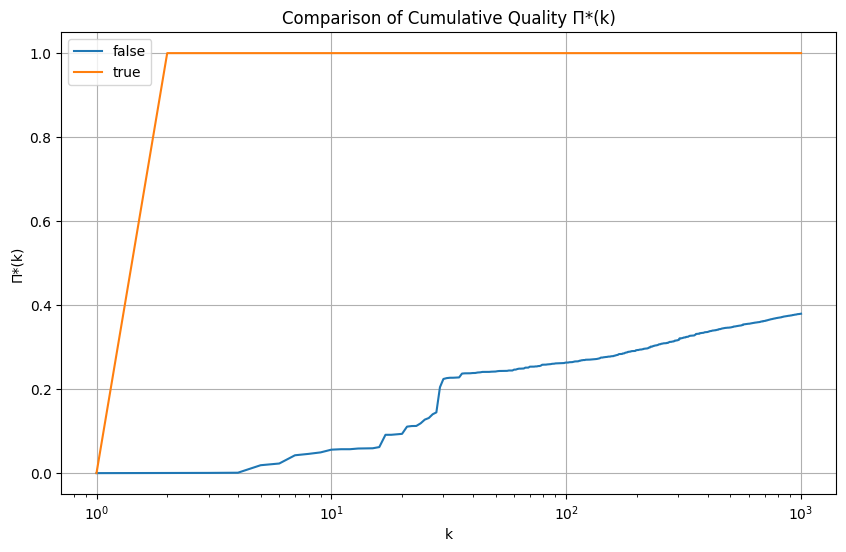


Statistics for false:
Final cumulative quality: 0.3796
Number of features needed for 90% quality: 1001

Statistics for true:
Final cumulative quality: 1.0000
Number of features needed for 90% quality: 2


In [3]:
import torch
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
from typing import List, Set

# First define the MSP function exactly as in your training code
class MSPFunction:
    def __init__(self, P: int, sets: List[Set[int]]):
        self.P = P
        self.sets = sets
    
    def evaluate(self, z: torch.Tensor) -> torch.Tensor:
        device = z.device
        batch_size = z.shape[0]
        result = torch.zeros(batch_size, dtype=torch.float32, device=device)
        
        for S in self.sets:
            term = torch.ones(batch_size, dtype=torch.float32, device=device)
            for idx in S:
                term = term * z[:, idx]
            result = result + term
            
        return result

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            layers.extend([
                torch.nn.Linear(prev_dim, hidden_size),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def get_feature_matrix(model, X):
    """Get the feature matrix (pre-last layer activations) for input X"""
    model.eval()
    with torch.no_grad():
        # Remove the last layer
        feature_extractor = torch.nn.Sequential(*list(model.network.children())[:-1])
        features = feature_extractor(X)
    return features

def calculate_cumulative_quality(feature_matrix, target_function, max_k=None):
    """Calculate eigenfunctions and cumulative quality Π*(k)"""
    # Calculate eigenfunctions using SVD
    U, S, _ = torch.linalg.svd(feature_matrix, full_matrices=False)
    
    if max_k is None:
        max_k = U.shape[1]
    
    # Apply QR decomposition for numerical stability
    Q, R = qr(U.cpu().numpy())
    Q = torch.tensor(Q, device=U.device)
    
    cumulative_quality = torch.zeros(max_k)
    
    for k in range(max_k):
        # Take first k eigenvectors
        Qk = Q[:, :k+1]
        
        # Calculate projection onto target function
        projection = torch.matmul(Qk, torch.matmul(Qk.T, target_function))
        quality = torch.norm(projection)**2 / torch.norm(target_function)**2
        cumulative_quality[k] = quality
        
    return cumulative_quality, S

def plot_cumulative_qualities(qualities_list, labels, title="Cumulative Quality Π*(k)", save_path=None):
    plt.figure(figsize=(10, 6))
    
    for qualities, label in zip(qualities_list, labels):
        plt.plot(range(1, len(qualities) + 1), qualities.cpu().numpy(), label=label)
    
    plt.xlabel('k')
    plt.ylabel('Π*(k)')
    plt.title(title)
    plt.grid(True)
    plt.xscale('log')
    plt.legend()
    
    if save_path:
        plt.savefig(save_path)
    
    return plt

# FILL IN THESE VALUES:
MODEL_PATH_1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/final_model_h1000_d4_n30000_lr0.001_mup_pennington_20250104_183809_rank0.pt"  # Path to first model
DATASET_PATH_1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/train_dataset_h1000_d4_n30000_lr0.001_mup_pennington_20250104_183809_rank0.pt"  # Path to first dataset
LABEL_1 = "false"  # Label for first model

MODEL_PATH_1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/initial_model_h1000_d4_n30000_lr0.001_mup_pennington_20250104_183809_rank0.pt"  # Path to first model
DATASET_PATH_1 = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_newmsp/train_dataset_h1000_d4_n30000_lr0.001_mup_pennington_20250104_183809_rank0.pt"  # Path to first dataset  # Path to second dataset
LABEL_2 = "true"  # Label for second model

MSP_SETS = [{1},{1,3},{4},{2,4},{0,2,1},{1,5,4},{6},{0,7},{7,8,0,1,2},{0,1,2,3,4,6,7,10},{1,9,3}]  # Confirm these are your sets
P = 9  # The P value you used
d = 35  # Input dimension
hidden_size = 1000  # Model hidden size
depth = 4  # Model depth
mode = 'mup_pennington'  # Model mode

# Optional: path to save the plot
SAVE_PLOT_PATH = None  # e.g., "feature_quality_comparison.png"

# Load everything
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to process one model
def process_model(model_path, dataset_path):
    # Load dataset
    dataset = torch.load(dataset_path)
    X = dataset['X'].to(device)
    y = dataset['y'].to(device)
    
    # Initialize model and load weights
    model = DeepNN(d, hidden_size, depth, mode).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Get feature matrix
    feature_matrix = get_feature_matrix(model, X)
    
    # Calculate cumulative quality
    qualities, singular_values = calculate_cumulative_quality(feature_matrix, y)
    
    return qualities, singular_values

# Process both models
qualities_1, singular_values_1 = process_model(MODEL_PATH_1, DATASET_PATH_1)
qualities_2, singular_values_2 = process_model(MODEL_PATH_2, DATASET_PATH_2)

# Plot both curves
plt = plot_cumulative_qualities(
    [qualities_1, qualities_2],
    [LABEL_1, LABEL_2],
    title="Comparison of Cumulative Quality Π*(k)",
    save_path=SAVE_PLOT_PATH
)
plt.show()

# Print statistics for both models
print(f"\nStatistics for {LABEL_1}:")
print(f"Final cumulative quality: {qualities_1[-1]:.4f}")
print(f"Number of features needed for 90% quality: {torch.sum(qualities_1 < 0.9).item() + 1}")

print(f"\nStatistics for {LABEL_2}:")
print(f"Final cumulative quality: {qualities_2[-1]:.4f}")
print(f"Number of features needed for 90% quality: {torch.sum(qualities_2 < 0.9).item() + 1}")

In [ ]:
#######

Successfully loaded n=10 from rank 0

Statistics for n=10:
Final cumulative quality: 1.0000
Number of features needed for 90% quality: 1
Successfully loaded n=100 from rank 1

Statistics for n=100:
Final cumulative quality: 1.0000
Number of features needed for 90% quality: 2
Successfully loaded n=1000 from rank 1

Statistics for n=1000:
Final cumulative quality: 1.0000
Number of features needed for 90% quality: 3
Successfully loaded n=10000 from rank 0

Statistics for n=10000:
Final cumulative quality: 1.0000
Number of features needed for 90% quality: 3
Successfully loaded n=30000 from rank 0

Statistics for n=30000:
Final cumulative quality: 1.0000
Number of features needed for 90% quality: 3


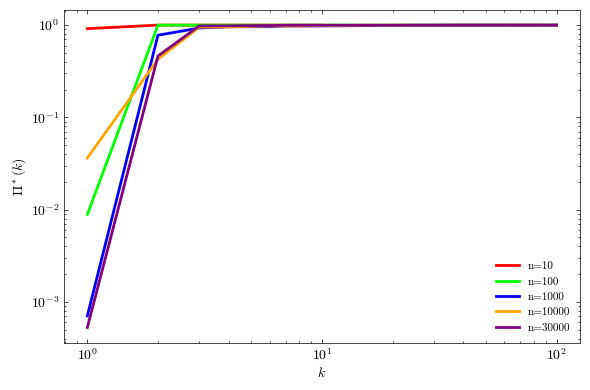

In [3]:
import torch
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Neural Network class and utility functions remain the same
class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            layers.extend([
                torch.nn.Linear(prev_dim, hidden_size),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def get_feature_matrix(model, X):
    model.eval()
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.network.children())[:-1])
        features = feature_extractor(X)
    return features

def calculate_cumulative_quality(feature_matrix, target_function, max_k=None):
    U, S, _ = torch.linalg.svd(feature_matrix, full_matrices=False)
    
    if max_k is None:
        max_k = U.shape[1]
    
    Q, R = qr(U.cpu().numpy())
    Q = torch.tensor(Q, device=U.device)
    
    cumulative_quality = torch.zeros(max_k)
    
    for k in range(max_k):
        Qk = Q[:, :k+1]
        projection = torch.matmul(Qk, torch.matmul(Qk.T, target_function))
        quality = torch.norm(projection)**2 / torch.norm(target_function)**2
        cumulative_quality[k] = quality
        
    return cumulative_quality, S

def setup_science_style():
    plt.style.use('default')
    mpl.rcParams.update({
        'figure.figsize': (4, 3),
        'figure.dpi': 100,
        'font.family': 'serif',
        'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
        'text.usetex': False,
        'axes.formatter.use_mathtext': True,
        'mathtext.fontset': 'cm',
        'axes.linewidth': 0.5,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 1.5,
        'ytick.minor.size': 1.5,
        'xtick.top': True,
        'ytick.right': True,
    })

def find_files_for_n(base_dir, n):
    """Find model and dataset files for a given n across all ranks"""
    for rank in range(3):  # Check ranks 0, 1, 2
        model_name = f'final_model_h400_d4_n{n}_lr0.05_mup_pennington_20250114_172146_rank{rank}.pt'
        dataset_name = f'train_dataset_h400_d4_n{n}_lr0.05_mup_pennington_20250114_172146_rank{rank}.pt'
        
        model_path = os.path.join(base_dir, model_name)
        dataset_path = os.path.join(base_dir, dataset_name)
        
        if os.path.exists(model_path) and os.path.exists(dataset_path):
            return model_path, dataset_path, rank
            
    return None, None, None

def load_model_and_dataset(base_dir, n):
    """Load a specific model and its dataset from any available rank"""
    model_path, dataset_path, rank = find_files_for_n(base_dir, n)
    
    if model_path is None:
        print(f"No files found for n={n} in any rank")
        return None, None, None
    
    try:
        # Load dataset
        dataset = torch.load(dataset_path, weights_only=True)
        X = dataset['X']
        y = dataset['y']
        
        # Initialize and load model
        model = DeepNN(d=30, hidden_size=400, depth=4, mode='mup_pennington')
        model.load_state_dict(torch.load(model_path, weights_only=True))
        
        print(f"Successfully loaded n={n} from rank {rank}")
        return model, X, y
    except Exception as e:
        print(f"Error loading n={n} from rank {rank}: {str(e)}")
        return None, None, None

def main():
    # Configuration
    BASE_DIR = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_1401_yoonsoo"
    N_TRAIN_VALUES = [10, 100, 1000, 10000, 30000]
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Color scheme
    COLORS = {
        10: '#FF0000',      # Red
        100: '#00FF00',     # Green
        1000: '#0000FF',    # Blue
        10000: '#FFA500',   # Orange
        30000: '#800080'    # Purple
    }
    
    # Load models and calculate qualities
    qualities_dict = {}
    
    for n in N_TRAIN_VALUES:
        model, X, y = load_model_and_dataset(BASE_DIR, n)
        if model is not None:
            # Move to device
            model = model.to(DEVICE)
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            
            # Calculate feature matrix and quality
            feature_matrix = get_feature_matrix(model, X)
            qualities, _ = calculate_cumulative_quality(feature_matrix, y)
            qualities_dict[n] = qualities
            
            # Print statistics
            print(f"\nStatistics for n={n}:")
            print(f"Final cumulative quality: {qualities[-1]:.4f}")
            print(f"Number of features needed for 90% quality: {torch.sum(qualities < 0.9).item() + 1}")
    
    # Create plot
    setup_science_style()
    fig, ax = plt.subplots(figsize=(6, 4))
    
    for n, qualities in qualities_dict.items():
        qualities_np = qualities.cpu().numpy()[:100]  # First 100 points
        x = np.arange(1, len(qualities_np) + 1)
        ax.plot(x, qualities_np, color=COLORS[n], linewidth=2.0, label=f'n={n}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.minorticks_on()
    
    ax.set_xlabel(r'$k$', labelpad=2)
    ax.set_ylabel(r'$\Pi^*(k)$', labelpad=2)
    ax.legend(loc='lower right', fontsize=8, frameon=False)
    
    plt.tight_layout()
    plt.savefig("quality_comparison.pdf", dpi=300, bbox_inches='tight', pad_inches=0.02)
    plt.show()

if __name__ == "__main__":
    main()

Found n_train values: [10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 5000, 8000, 10000, 15000, 20000, 30000]
Successfully loaded n=10 from rank 0
n=10: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=50 from rank 0
n=50: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=100 from rank 0
n=100: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=200 from rank 0
n=200: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=300 from rank 0
n=300: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=400 from rank 0
n=400: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=500 from rank 0
n=500: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=800 from rank 0
n=800: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=1000 from rank 0
n=1000: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=2500 from rank 0
n=2500: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=5000 

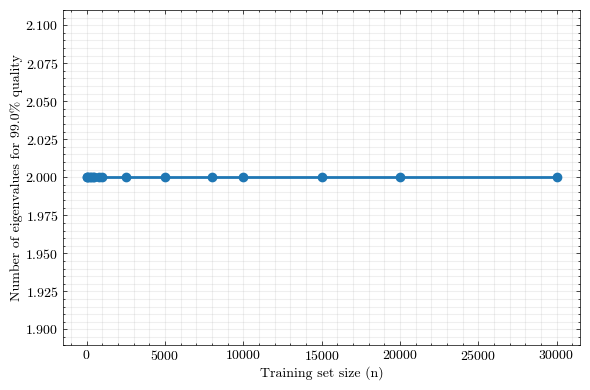


Data points:
n=10: k=2
n=50: k=2
n=100: k=2
n=200: k=2
n=300: k=2
n=400: k=2
n=500: k=2
n=800: k=2
n=1000: k=2
n=2500: k=2
n=5000: k=2
n=8000: k=2
n=10000: k=2
n=15000: k=2
n=20000: k=2
n=30000: k=2


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.linalg import qr

import torch
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Neural Network class and utility functions remain the same
class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            layers.extend([
                torch.nn.Linear(prev_dim, hidden_size),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def get_feature_matrix(model, X):
    model.eval()
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.network.children())[:-1])
        features = feature_extractor(X)
    return features

def calculate_cumulative_quality(feature_matrix, target_function, max_k=None):
    U, S, _ = torch.linalg.svd(feature_matrix, full_matrices=False)
    
    if max_k is None:
        max_k = U.shape[1]
    
    Q, R = qr(U.cpu().numpy())
    Q = torch.tensor(Q, device=U.device)
    
    cumulative_quality = torch.zeros(max_k)
    
    for k in range(max_k):
        Qk = Q[:, :k+1]
        projection = torch.matmul(Qk, torch.matmul(Qk.T, target_function))
        quality = torch.norm(projection)**2 / torch.norm(target_function)**2
        cumulative_quality[k] = quality
        
    return cumulative_quality, S

def setup_science_style():
    plt.style.use('default')
    mpl.rcParams.update({
        'figure.figsize': (4, 3),
        'figure.dpi': 100,
        'font.family': 'serif',
        'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
        'text.usetex': False,
        'axes.formatter.use_mathtext': True,
        'mathtext.fontset': 'cm',
        'axes.linewidth': 0.5,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 1.5,
        'ytick.minor.size': 1.5,
        'xtick.top': True,
        'ytick.right': True,
    })


def get_n_values_from_directory(base_dir):
    """Extract all unique n values from the model filenames in directory"""
    n_values = set()
    prefix = "final_model_h2000_d4_n"
    
    for file in os.listdir(base_dir):
        if file.startswith(prefix):
            # Extract n value from filename
            n_str = file.split(prefix)[1].split("_")[0]
            try:
                n = int(n_str)
                n_values.add(n)
            except ValueError:
                continue
    
    return sorted(list(n_values))

def get_k_for_quality_threshold(qualities, threshold=0.95):
    """Get the number of eigenvalues needed to reach the quality threshold"""
    for k, quality in enumerate(qualities):
        if quality >= threshold:
            return k + 1
    return len(qualities)  # Return max k if threshold not reached

def find_files_for_n(base_dir, n):
    """Find model and dataset files for a given n across all ranks"""
    for rank in range(3):  # Check ranks 0, 1, 2
        model_name = f'final_model_h2000_d4_n{n}_lr0.001_mup_pennington_shuffled_20250115_162207_rank{rank}.pt'
        dataset_name = f'train_dataset_h2000_d4_n{n}_lr0.001_mup_pennington_shuffled_20250115_162207_rank{rank}.pt'
        
        model_path = os.path.join(base_dir, model_name)
        dataset_path = os.path.join(base_dir, dataset_name)
        
        if os.path.exists(model_path) and os.path.exists(dataset_path):
            return model_path, dataset_path, rank
            
    return None, None, None

def load_model_and_dataset(base_dir, n):
    """Load a specific model and its dataset from any available rank"""
    model_path, dataset_path, rank = find_files_for_n(base_dir, n)
    
    if model_path is None:
        print(f"No files found for n={n} in any rank")
        return None, None, None
    
    try:
        # Load dataset
        dataset = torch.load(dataset_path, weights_only=True)
        X = dataset['X']
        y = dataset['y']
        
        # Initialize and load model
        model = DeepNN(d=40, hidden_size=2000, depth=4, mode='mup_pennington')
        model.load_state_dict(torch.load(model_path, weights_only=True))
        
        print(f"Successfully loaded n={n} from rank {rank}")
        return model, X, y
    except Exception as e:
        print(f"Error loading n={n} from rank {rank}: {str(e)}")
        return None, None, None


def main():
    # Configuration
    BASE_DIR = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_1401_yoonsoo_true_lr001"
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    QUALITY_THRESHOLD = 0.99
    
    # Get all n values from directory
    n_train_values = get_n_values_from_directory(BASE_DIR)
    print(f"Found n_train values: {n_train_values}")
    
    # Dictionary to store k values for each n
    k_values = {}
    
    # Process each n value
    for n in n_train_values:
        model, X, y = load_model_and_dataset(BASE_DIR, n)
        if model is not None:
            # Move to device
            model = model.to(DEVICE)
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            
            # Calculate feature matrix and quality
            feature_matrix = get_feature_matrix(model, X)
            qualities, _ = calculate_cumulative_quality(feature_matrix, y)
            
            # Get k value for 95% quality
            k = get_k_for_quality_threshold(qualities, QUALITY_THRESHOLD)
            k_values[n] = k
            
            print(f"n={n}: k={k} eigenvalues needed for {QUALITY_THRESHOLD*100}% quality")
    
    # Create plot
    setup_science_style()
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Extract x and y values for plotting
    n_plot = np.array(sorted(k_values.keys()))
    k_plot = np.array([k_values[n] for n in n_plot])
    
    # Plot with log scales
    ax.plot(n_plot, k_plot, 'o-', color='#1f77b4', linewidth=2, markersize=6)
    
    
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.minorticks_on()
    
    ax.set_xlabel('Training set size (n)', labelpad=2)
    ax.set_ylabel(f'Number of eigenvalues for {QUALITY_THRESHOLD*100}% quality', labelpad=2)
    
    # Add grid
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.savefig("eigenvalues_vs_n.pdf", dpi=300, bbox_inches='tight', pad_inches=0.02)
    plt.show()
    
    # Print the data points
    print("\nData points:")
    for n in sorted(k_values.keys()):
        print(f"n={n}: k={k_values[n]}")

if __name__ == "__main__":
    main()

Found n_train values: [10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 5000, 8000, 10000, 15000, 20000, 30000]
Successfully loaded n=10 from rank 0
n=10: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=50 from rank 0
n=50: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=100 from rank 0
n=100: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=200 from rank 0
n=200: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=300 from rank 0
n=300: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=400 from rank 0
n=400: k=2 eigenvalues needed for 99.0% quality
Successfully loaded n=500 from rank 0
n=500: k=4 eigenvalues needed for 99.0% quality
Successfully loaded n=800 from rank 0
n=800: k=3 eigenvalues needed for 99.0% quality
Successfully loaded n=1000 from rank 0
n=1000: k=4 eigenvalues needed for 99.0% quality
Successfully loaded n=2500 from rank 0
n=2500: k=3 eigenvalues needed for 99.0% quality
Successfully loaded n=5000 

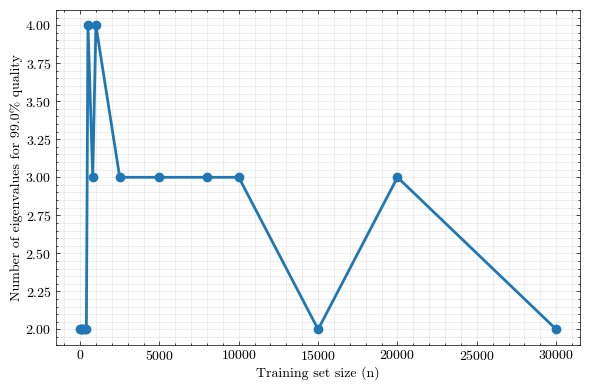


Data points:
n=10: k=2
n=50: k=2
n=100: k=2
n=200: k=2
n=300: k=2
n=400: k=2
n=500: k=4
n=800: k=3
n=1000: k=4
n=2500: k=3
n=5000: k=3
n=8000: k=3
n=10000: k=3
n=15000: k=2
n=20000: k=3
n=30000: k=2


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.linalg import qr

import torch
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Neural Network class and utility functions remain the same
class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            layers.extend([
                torch.nn.Linear(prev_dim, hidden_size),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def get_feature_matrix(model, X):
    model.eval()
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.network.children())[:-1])
        features = feature_extractor(X)
    return features

def calculate_cumulative_quality(feature_matrix, target_function, max_k=None):
    U, S, _ = torch.linalg.svd(feature_matrix, full_matrices=False)
    
    if max_k is None:
        max_k = U.shape[1]
    
    Q, R = qr(U.cpu().numpy())
    Q = torch.tensor(Q, device=U.device)
    
    cumulative_quality = torch.zeros(max_k)
    
    for k in range(max_k):
        Qk = Q[:, :k+1]
        projection = torch.matmul(Qk, torch.matmul(Qk.T, target_function))
        quality = torch.norm(projection)**2 / torch.norm(target_function)**2
        cumulative_quality[k] = quality
        
    return cumulative_quality, S

def setup_science_style():
    plt.style.use('default')
    mpl.rcParams.update({
        'figure.figsize': (4, 3),
        'figure.dpi': 100,
        'font.family': 'serif',
        'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
        'text.usetex': False,
        'axes.formatter.use_mathtext': True,
        'mathtext.fontset': 'cm',
        'axes.linewidth': 0.5,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 1.5,
        'ytick.minor.size': 1.5,
        'xtick.top': True,
        'ytick.right': True,
    })


def get_n_values_from_directory(base_dir):
    """Extract all unique n values from the model filenames in directory"""
    n_values = set()
    prefix = "final_model_h1000_d4_n"
    
    for file in os.listdir(base_dir):
        if file.startswith(prefix):
            # Extract n value from filename
            n_str = file.split(prefix)[1].split("_")[0]
            try:
                n = int(n_str)
                n_values.add(n)
            except ValueError:
                continue
    
    return sorted(list(n_values))

def get_k_for_quality_threshold(qualities, threshold=0.95):
    """Get the number of eigenvalues needed to reach the quality threshold"""
    for k, quality in enumerate(qualities):
        if quality >= threshold:
            return k + 1
    return len(qualities)  # Return max k if threshold not reached

def find_files_for_n(base_dir, n):
    """Find model and dataset files for a given n across all ranks"""
    for rank in range(3):  # Check ranks 0, 1, 2
        model_name = f'final_model_h1000_d4_n{n}_lr0.001_mup_pennington_20250105_035211_rank{rank}.pt'
        dataset_name = f'train_dataset_h1000_d4_n{n}_lr0.001_mup_pennington_20250105_035211_rank{rank}.pt'
        
        model_path = os.path.join(base_dir, model_name)
        dataset_path = os.path.join(base_dir, dataset_name)
        
        if os.path.exists(model_path) and os.path.exists(dataset_path):
            return model_path, dataset_path, rank
            
    return None, None, None

def load_model_and_dataset(base_dir, n):
    """Load a specific model and its dataset from any available rank"""
    model_path, dataset_path, rank = find_files_for_n(base_dir, n)
    
    if model_path is None:
        print(f"No files found for n={n} in any rank")
        return None, None, None
    
    try:
        # Load dataset
        dataset = torch.load(dataset_path, weights_only=True)
        X = dataset['X']
        y = dataset['y']
        
        # Initialize and load model
        model = DeepNN(d=35, hidden_size=1000, depth=4, mode='mup_pennington')
        model.load_state_dict(torch.load(model_path, weights_only=True))
        
        print(f"Successfully loaded n={n} from rank {rank}")
        return model, X, y
    except Exception as e:
        print(f"Error loading n={n} from rank {rank}: {str(e)}")
        return None, None, None


def main():
    # Configuration
    BASE_DIR = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_standard_0401_shuffled_mup_false_antro_oldmsp"
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    QUALITY_THRESHOLD = 0.99
    
    # Get all n values from directory
    n_train_values = get_n_values_from_directory(BASE_DIR)
    print(f"Found n_train values: {n_train_values}")
    
    # Dictionary to store k values for each n
    k_values = {}
    
    # Process each n value
    for n in n_train_values:
        model, X, y = load_model_and_dataset(BASE_DIR, n)
        if model is not None:
            # Move to device
            model = model.to(DEVICE)
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            
            # Calculate feature matrix and quality
            feature_matrix = get_feature_matrix(model, X)
            qualities, _ = calculate_cumulative_quality(feature_matrix, y)
            
            # Get k value for 95% quality
            k = get_k_for_quality_threshold(qualities, QUALITY_THRESHOLD)
            k_values[n] = k
            
            print(f"n={n}: k={k} eigenvalues needed for {QUALITY_THRESHOLD*100}% quality")
    
    # Create plot
    setup_science_style()
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Extract x and y values for plotting
    n_plot = np.array(sorted(k_values.keys()))
    k_plot = np.array([k_values[n] for n in n_plot])
    
    # Plot with log scales
    ax.plot(n_plot, k_plot, 'o-', color='#1f77b4', linewidth=2, markersize=6)
    
    
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.minorticks_on()
    
    ax.set_xlabel('Training set size (n)', labelpad=2)
    ax.set_ylabel(f'Number of eigenvalues for {QUALITY_THRESHOLD*100}% quality', labelpad=2)
    
    # Add grid
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.savefig("eigenvalues_vs_n.pdf", dpi=300, bbox_inches='tight', pad_inches=0.02)
    plt.show()
    
    # Print the data points
    print("\nData points:")
    for n in sorted(k_values.keys()):
        print(f"n={n}: k={k_values[n]}")

if __name__ == "__main__":
    main()

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.linalg import qr

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            layers.extend([
                torch.nn.Linear(prev_dim, hidden_size),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def get_feature_matrix(model, X):
    model.eval()
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.network.children())[:-1])
        features = feature_extractor(X)
    return features

def calculate_cumulative_quality(feature_matrix, target_function, max_k=None):
    U, S, _ = torch.linalg.svd(feature_matrix, full_matrices=False)
    
    if max_k is None:
        max_k = U.shape[1]
    
    Q, R = qr(U.cpu().numpy())
    Q = torch.tensor(Q, device=U.device)
    
    cumulative_quality = torch.zeros(max_k)
    
    for k in range(max_k):
        Qk = Q[:, :k+1]
        projection = torch.matmul(Qk, torch.matmul(Qk.T, target_function))
        quality = torch.norm(projection)**2 / torch.norm(target_function)**2
        cumulative_quality[k] = quality
        
    return cumulative_quality, S

def setup_science_style():
    plt.style.use('default')
    mpl.rcParams.update({
        'figure.figsize': (4, 3),
        'figure.dpi': 100,
        'font.family': 'serif',
        'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
        'text.usetex': False,
        'axes.formatter.use_mathtext': True,
        'mathtext.fontset': 'cm',
        'axes.linewidth': 0.5,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 0.5,
        'ytick.major.width': 0.5,
        'xtick.minor.width': 0.5,
        'ytick.minor.width': 0.5,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'xtick.minor.size': 1.5,
        'ytick.minor.size': 1.5,
        'xtick.top': True,
        'ytick.right': True,
    })

def get_n_values_from_directory(base_dir):
    n_values = set()
    prefix = "final_model_h400_d4_n"
    
    for file in os.listdir(base_dir):
        if file.startswith(prefix):
            n_str = file.split(prefix)[1].split("_")[0]
            try:
                n = int(n_str)
                n_values.add(n)
            except ValueError:
                continue
    
    return sorted(list(n_values))

def find_files_for_n(base_dir, n):
    """Find model and dataset files for a given n across all ranks"""
    for rank in range(3):  # Check ranks 0, 1, 2
        model_name = f'final_model_h400_d4_n{n}_lr0.05_mup_pennington_20250114_172146_rank{rank}.pt'
        
        model_path = os.path.join(base_dir, model_name)
        if os.path.exists(model_path):
            return model_path, rank
            
    return None, None

def get_k_for_quality_threshold(qualities, threshold=0.95):
    for k, quality in enumerate(qualities):
        if quality >= threshold:
            return k + 1
    return len(qualities)

def main():
    # Configuration
    BASE_DIR = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_1401_yoonsoo"
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    QUALITY_THRESHOLD = 0.95
    
    # Load test dataset
    test_dataset_path = os.path.join(BASE_DIR, "test_dataset_20250114_172146.pt")
    test_data = torch.load(test_dataset_path, weights_only=True)
    X_test = test_data['X'].to(DEVICE)
    y_test = test_data['y'].to(DEVICE)
    print(f"Loaded test dataset with shape: {X_test.shape}")
    
    # Get all n values from directory
    n_train_values = get_n_values_from_directory(BASE_DIR)
    print(f"Found n_train values: {n_train_values}")
    
    # Dictionary to store k values for each n
    k_values = {}
    
    # Process each n value
    for n in n_train_values:
        model_path, rank = find_files_for_n(BASE_DIR, n)
        if model_path is not None:
            try:
                # Initialize model with correct input dimension
                d = X_test.shape[1]
                model = DeepNN(d=d, hidden_size=400, depth=4, mode='mup_pennington')
                model.load_state_dict(torch.load(model_path, weights_only=True))
                model = model.to(DEVICE)
                model.eval()
                
                # Calculate feature matrix and quality on test set
                feature_matrix = get_feature_matrix(model, X_test)
                qualities, _ = calculate_cumulative_quality(feature_matrix, y_test)
                
                # Get k value for 95% quality
                k = get_k_for_quality_threshold(qualities, QUALITY_THRESHOLD)
                k_values[n] = k
                
                print(f"n={n} (rank {rank}): k={k} eigenvalues needed for {QUALITY_THRESHOLD*100}% test quality")
            except Exception as e:
                print(f"Error processing n={n}: {str(e)}")
    
    # Create plot
    setup_science_style()
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Extract x and y values for plotting
    n_plot = np.array(sorted(k_values.keys()))
    k_plot = np.array([k_values[n] for n in n_plot])
    
    # Plot with log scales
    ax.plot(n_plot, k_plot, 'o-', color='#1f77b4', linewidth=2, markersize=6)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.minorticks_on()
    
    ax.set_xlabel('Training set size (n)', labelpad=2)
    ax.set_ylabel(f'Number of eigenvalues for {QUALITY_THRESHOLD*100}% test quality', labelpad=2)
    
    # Add grid
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    plt.tight_layout()
    plt.savefig("test_eigenvalues_vs_n.pdf", dpi=300, bbox_inches='tight', pad_inches=0.02)
    plt.show()
    
    # Print the data points
    print("\nData points:")
    for n in sorted(k_values.keys()):
        print(f"n={n}: k={k_values[n]}")

if __name__ == "__main__":
    main()

Loaded test dataset with shape: torch.Size([1000, 30])
Found n_train values: [10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 5000, 8000, 10000, 15000, 20000, 30000]
n=10 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=50 (rank 2): k=400 eigenvalues needed for 95.0% test quality
n=100 (rank 1): k=400 eigenvalues needed for 95.0% test quality
n=200 (rank 0): k=400 eigenvalues needed for 95.0% test quality


KeyboardInterrupt: 

Loaded test dataset with shape: torch.Size([1000, 30])
Found n_train values: [10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 5000, 8000, 10000, 15000, 20000, 30000]
n=10 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=50 (rank 2): k=400 eigenvalues needed for 95.0% test quality
n=100 (rank 1): k=400 eigenvalues needed for 95.0% test quality
n=200 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=300 (rank 2): k=400 eigenvalues needed for 95.0% test quality
n=400 (rank 1): k=400 eigenvalues needed for 95.0% test quality
n=500 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=800 (rank 2): k=10 eigenvalues needed for 95.0% test quality
n=1000 (rank 1): k=4 eigenvalues needed for 95.0% test quality
n=2500 (rank 0): k=3 eigenvalues needed for 95.0% test quality
n=5000 (rank 2): k=3 eigenvalues needed for 95.0% test quality
n=8000 (rank 1): k=4 eigenvalues needed for 95.0% test quality
n=10000 (rank 0): k=3 eigenvalues needed for 95.0% test quality
n=15000

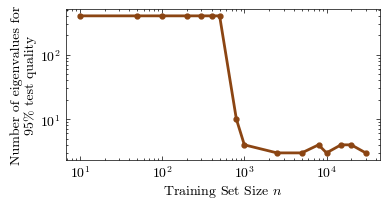


Data points:
n=10: k=400
n=50: k=400
n=100: k=400
n=200: k=400
n=300: k=400
n=400: k=400
n=500: k=400
n=800: k=10
n=1000: k=4
n=2500: k=3
n=5000: k=3
n=8000: k=4
n=10000: k=3
n=15000: k=4
n=20000: k=4
n=30000: k=3


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.linalg import qr
from dataclasses import dataclass
from typing import Optional

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    BROWN = '#8B4513'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (2.8, 3.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def configure_axes(self, ax):
        """Configure axes with different formatting for x and y axes"""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        ax.tick_params(which='both', direction='in')

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            layers.extend([
                torch.nn.Linear(prev_dim, hidden_size),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def get_feature_matrix(model, X):
    model.eval()
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.network.children())[:-1])
        features = feature_extractor(X)
    return features

def calculate_cumulative_quality(feature_matrix, target_function, max_k=None):
    U, S, _ = torch.linalg.svd(feature_matrix, full_matrices=False)
    
    if max_k is None:
        max_k = U.shape[1]
    
    Q, R = qr(U.cpu().numpy())
    Q = torch.tensor(Q, device=U.device)
    
    cumulative_quality = torch.zeros(max_k)
    
    for k in range(max_k):
        Qk = Q[:, :k+1]
        projection = torch.matmul(Qk, torch.matmul(Qk.T, target_function))
        quality = torch.norm(projection)**2 / torch.norm(target_function)**2
        cumulative_quality[k] = quality
        
    return cumulative_quality, S

def get_n_values_from_directory(base_dir):
    n_values = set()
    prefix = "final_model_h400_d4_n"
    
    for file in os.listdir(base_dir):
        if file.startswith(prefix):
            n_str = file.split(prefix)[1].split("_")[0]
            try:
                n = int(n_str)
                n_values.add(n)
            except ValueError:
                continue
    
    return sorted(list(n_values))

def find_files_for_n(base_dir, n):
    """Find model and dataset files for a given n across all ranks"""
    for rank in range(3):  # Check ranks 0, 1, 2
        model_name = f'final_model_h400_d4_n{n}_lr0.05_mup_pennington_20250114_172146_rank{rank}.pt'
        
        model_path = os.path.join(base_dir, model_name)
        if os.path.exists(model_path):
            return model_path, rank
            
    return None, None

def get_k_for_quality_threshold(qualities, threshold=0.95):
    for k, quality in enumerate(qualities):
        if quality >= threshold:
            return k + 1
    return len(qualities)

def plot_eigenvalue_analysis(n_values, k_values, quality_threshold):
    """Create scientific plot for eigenvalue analysis."""
    plotter = SciencePlotter()
    
    # Create plot with specified size
    fig, ax = plt.subplots(figsize=(4.0, 2.2))
    
    # Style for the single line
    style = PlotStyle(
        color=plotter.BROWN,
        linestyle='-',
        linewidth=2.0,
        marker='o',
        markersize=3.5,
        label="Required eigenvalues"
    )
    
    # Plot data
    ax.plot(n_values, k_values,
            color=style.color,
            linestyle=style.linestyle,
            linewidth=style.linewidth,
            marker=style.marker,
            markersize=style.markersize,
            label=style.label)
    
    plotter.configure_axes(ax)
    ax.set_xlabel(r'Training Set Size $n$', labelpad=2)
    ax.set_ylabel(f'Number of eigenvalues for\n{quality_threshold*100:.0f}% test quality', labelpad=2)
    plt.tight_layout()
    
    return fig

def main():
    # Configuration
    BASE_DIR = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_1401_yoonsoo"
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    QUALITY_THRESHOLD = 0.95
    
    # Load test dataset
    test_dataset_path = os.path.join(BASE_DIR, "test_dataset_20250114_172146.pt")
    test_data = torch.load(test_dataset_path, weights_only=True)
    X_test = test_data['X'].to(DEVICE)
    y_test = test_data['y'].to(DEVICE)
    print(f"Loaded test dataset with shape: {X_test.shape}")
    
    # Get all n values from directory
    n_train_values = get_n_values_from_directory(BASE_DIR)
    print(f"Found n_train values: {n_train_values}")
    
    # Dictionary to store k values for each n
    k_values = {}
    
    # Process each n value
    for n in n_train_values:
        model_path, rank = find_files_for_n(BASE_DIR, n)
        if model_path is not None:
            try:
                # Initialize model with correct input dimension
                d = X_test.shape[1]
                model = DeepNN(d=d, hidden_size=400, depth=4, mode='mup_pennington')
                model.load_state_dict(torch.load(model_path, weights_only=True))
                model = model.to(DEVICE)
                model.eval()
                
                # Calculate feature matrix and quality on test set
                feature_matrix = get_feature_matrix(model, X_test)
                qualities, _ = calculate_cumulative_quality(feature_matrix, y_test)
                
                # Get k value for 95% quality
                k = get_k_for_quality_threshold(qualities, QUALITY_THRESHOLD)
                k_values[n] = k
                
                print(f"n={n} (rank {rank}): k={k} eigenvalues needed for {QUALITY_THRESHOLD*100}% test quality")
            except Exception as e:
                print(f"Error processing n={n}: {str(e)}")
    
    # Extract x and y values for plotting
    n_plot = np.array(sorted(k_values.keys()))
    k_plot = np.array([k_values[n] for n in n_plot])
    
    # Create and save plot
    fig = plot_eigenvalue_analysis(n_plot, k_plot, QUALITY_THRESHOLD)
    
    # Save plot
    fig.savefig('eigenvalue_analysis.png', 
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig('eigenvalue_analysis.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    plt.show()
    
    # Print the data points
    print("\nData points:")
    for n in sorted(k_values.keys()):
        print(f"n={n}: k={k_values[n]}")

if __name__ == "__main__":
    main()

Loaded test dataset with shape: torch.Size([1000, 30])
Found n_train values: [10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 5000, 8000, 10000, 15000, 20000, 30000]
n=10 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=50 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=100 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=200 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=300 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=400 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=500 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=800 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=1000 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=2500 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=5000 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=8000 (rank 0): k=400 eigenvalues needed for 95.0% test quality
n=10000 (rank 0): k=400 eigenvalues needed for 95.0% test qual

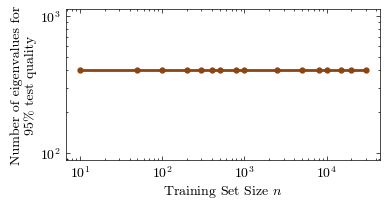


Data points:
n=10: k=400
n=50: k=400
n=100: k=400
n=200: k=400
n=300: k=400
n=400: k=400
n=500: k=400
n=800: k=400
n=1000: k=400
n=2500: k=400
n=5000: k=400
n=8000: k=400
n=10000: k=400
n=15000: k=400
n=20000: k=400
n=30000: k=400


In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.linalg import qr
from dataclasses import dataclass
from typing import Optional

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    BROWN = '#8B4513'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (2.8, 3.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def configure_axes(self, ax):
        """Configure axes with different formatting for x and y axes"""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        ax.tick_params(which='both', direction='in')

class DeepNN(torch.nn.Module):
    def __init__(self, d: int, hidden_size: int, depth: int, mode: str = 'special'):
        super().__init__()
        layers = []
        prev_dim = d
        
        for _ in range(depth):
            layers.extend([
                torch.nn.Linear(prev_dim, hidden_size),
                torch.nn.ReLU()
            ])
            prev_dim = hidden_size
        
        layers.append(torch.nn.Linear(prev_dim, 1))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

def get_feature_matrix(model, X):
    model.eval()
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.network.children())[:-1])
        features = feature_extractor(X)
    return features

def calculate_cumulative_quality(feature_matrix, target_function, max_k=None):
    U, S, _ = torch.linalg.svd(feature_matrix, full_matrices=False)
    
    if max_k is None:
        max_k = U.shape[1]
    
    Q, R = qr(U.cpu().numpy())
    Q = torch.tensor(Q, device=U.device)
    
    cumulative_quality = torch.zeros(max_k)
    
    for k in range(max_k):
        Qk = Q[:, :k+1]
        projection = torch.matmul(Qk, torch.matmul(Qk.T, target_function))
        quality = torch.norm(projection)**2 / torch.norm(target_function)**2
        cumulative_quality[k] = quality
        
    return cumulative_quality, S

def get_n_values_from_directory(base_dir):
    n_values = set()
    prefix = "final_model_h400_d4_n"
    
    for file in os.listdir(base_dir):
        if file.startswith(prefix):
            n_str = file.split(prefix)[1].split("_")[0]
            try:
                n = int(n_str)
                n_values.add(n)
            except ValueError:
                continue
    
    return sorted(list(n_values))

def find_files_for_n(base_dir, n):
    """Find model and dataset files for a given n across all ranks"""
    for rank in range(3):  # Check ranks 0, 1, 2
        model_name = f'final_model_h400_d4_n{n}_lr0.05_mup_pennington_shuffled_20250115_024314_rank{rank}.pt'
        
        model_path = os.path.join(base_dir, model_name)
        if os.path.exists(model_path):
            return model_path, rank
            
    return None, None

def get_k_for_quality_threshold(qualities, threshold=0.95):
    for k, quality in enumerate(qualities):
        if quality >= threshold:
            return k + 1
    return len(qualities)

def plot_eigenvalue_analysis(n_values, k_values, quality_threshold):
    """Create scientific plot for eigenvalue analysis."""
    plotter = SciencePlotter()
    
    # Create plot with specified size
    fig, ax = plt.subplots(figsize=(4.0, 2.2))
    
    # Style for the single line
    style = PlotStyle(
        color=plotter.BROWN,
        linestyle='-',
        linewidth=2.0,
        marker='o',
        markersize=3.5,
        label="Required eigenvalues"
    )
    
    # Plot data
    ax.plot(n_values, k_values,
            color=style.color,
            linestyle=style.linestyle,
            linewidth=style.linewidth,
            marker=style.marker,
            markersize=style.markersize,
            label=style.label)
    
    plotter.configure_axes(ax)
    ax.set_xlabel(r'Training Set Size $n$', labelpad=2)
    ax.set_ylabel(f'Number of eigenvalues for\n{quality_threshold*100:.0f}% test quality', labelpad=2)
    plt.tight_layout()
    
    return fig

def main():
    # Configuration
    BASE_DIR = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_1401_yoonsoo_true"
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    QUALITY_THRESHOLD = 0.95
    
    # Load test dataset
    test_dataset_path = os.path.join(BASE_DIR, "test_dataset_20250115_024314.pt")
    test_data = torch.load(test_dataset_path, weights_only=True)
    X_test = test_data['X'].to(DEVICE)
    y_test = test_data['y'].to(DEVICE)
    print(f"Loaded test dataset with shape: {X_test.shape}")
    
    # Get all n values from directory
    n_train_values = get_n_values_from_directory(BASE_DIR)
    print(f"Found n_train values: {n_train_values}")
    
    # Dictionary to store k values for each n
    k_values = {}
    
    # Process each n value
    for n in n_train_values:
        model_path, rank = find_files_for_n(BASE_DIR, n)
        if model_path is not None:
            try:
                # Initialize model with correct input dimension
                d = X_test.shape[1]
                model = DeepNN(d=d, hidden_size=400, depth=4, mode='mup_pennington')
                model.load_state_dict(torch.load(model_path, weights_only=True))
                model = model.to(DEVICE)
                model.eval()
                
                # Calculate feature matrix and quality on test set
                feature_matrix = get_feature_matrix(model, X_test)
                qualities, _ = calculate_cumulative_quality(feature_matrix, y_test)
                
                # Get k value for 95% quality
                k = get_k_for_quality_threshold(qualities, QUALITY_THRESHOLD)
                k_values[n] = k
                
                print(f"n={n} (rank {rank}): k={k} eigenvalues needed for {QUALITY_THRESHOLD*100}% test quality")
            except Exception as e:
                print(f"Error processing n={n}: {str(e)}")
    
    # Extract x and y values for plotting
    n_plot = np.array(sorted(k_values.keys()))
    k_plot = np.array([k_values[n] for n in n_plot])
    
    # Create and save plot
    fig = plot_eigenvalue_analysis(n_plot, k_plot, QUALITY_THRESHOLD)
    
    # Save plot
    fig.savefig('eigenvalue_analysis.png', 
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig('eigenvalue_analysis.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    plt.show()
    
    # Print the data points
    print("\nData points:")
    for n in sorted(k_values.keys()):
        print(f"n={n}: k={k_values[n]}")

if __name__ == "__main__":
    main()